# Project Question:
I hope to predict if a college basketball player will be drafted into the NBA. 

My main attributes will be traditional production (points, three point percentage, assists), what school did they attend (Kansas, Kentucky, Duke), what year they were (Freshman, Sophmore, Junior, Senior), and potentially some advanced metrics (WARP, WinShares, +/-), if I can calculate/obtain them.

## Additional Questions:
- What aspects of their performance will translate into professional play?
- What attributes of college performance are most influential?
    - What types of players are more likely to get drafted?
        - Clustering + Prediction
- What range of picks will be used to draft a player?
    - What pick exactly will be used to draft a player?

# What data are you planning to use to answer that question? 
I am planning to use the scrapers/datasets for NCAA basketball created by [Christopher D. Long](github.com/octonion), an analyst for the Detroit Tigers, and [great twitter follow](twitter.com/octonion). 

![](images/octonion-git.png)

The draft data is coming from [Basketball Reference](www.basketball-reference.com).

![](images/bbref-draft.png)


# What do you know about the data so far? 

I am familiar with basketball box scores, and I am aware of how noisy this data is, along with how rare it is for players to get drafted into the NBA.

# Why did you chose this topic? 

I like basketball, and I like sports analytics. Originally, I was going to perform an analysis about clustering NBA players into some groups and performing an evaluation of that model, but after talking to Michelle, I found this topic a lot more interesting. Also, the transition between the College and the NBA isn't very widely discussed in public spaces. This field is ripe for exploration in a public space, and I think it'd be cool to start this discussion.

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
data_dir = 'data/'

In [12]:
#loading in cleaned datasets
draft = pd.read_csv(data_dir + 'draft_clean.csv', sep = '\t', index_col = 0)
ncaa = pd.read_csv(data_dir + 'ncaa_players_clean.csv', sep = '\t', index_col = 0)

In [15]:
#creating dummy variable for being drafted, all players in this dataframe are 1
draft['dummy'] = 1
draft.head()

namekeys                 Player  Year  Rd  Pk   Tm  dummy
0          masonplumlee          Mason Plumlee  2013   1  22  BRK      1
1            rudygobert            Rudy Gobert  2013   1  27  DEN      1
2           stevenadams           Steven Adams  2013   1  12  OKC      1
3  giannisantetokounmpo  Giannis Antetokounmpo  2013   1  15  MIL      1
4            codyzeller            Cody Zeller  2013   1   4  CHA      1

In [14]:
ncaa.head()

school_name  school_id  year              name  player_id  \
0  A&M-Corpus Christi      26172  2013        Hameed Ali    1289295   
1  A&M-Corpus Christi      26172  2013     Jelani Currie    1402236   
2  A&M-Corpus Christi      26172  2013     Kennon Dvorak    1289297   
3  A&M-Corpus Christi      26172  2013      Dale Francis    1402237   
4  A&M-Corpus Christi      26172  2013  Johnathan Jordan    1289299   

  class_year   season position height games       ...         assists  \
0        So.  2012-13        G    6-2    29       ...              56   
1        Fr.  2012-13        G    6-4    18       ...               7   
2        Jr.  2012-13        G    6-2    13       ...               2   
3        Fr.  2012-13        F    6-9    29       ...               3   
4        So.  2012-13        G   5-10    29       ...             159   

   assists_per_game  blocks  blocks_per_game  steals  steals_per_game  points  \
0             1.931       5            0.172      42            1.448     218   
1             0.389       2            0.111       0            0.000      32   
2             0.154       0            0.000       2            0.154      14   
3             0.103       7            0.241       8            0.276      58   
4             5.483       5            0.172      39            1.345     372   

   points_per_game  turnovers         namekeys  
0            7.517         35        hameedali  
1            1.778         14     jelanicurrie  
2            1.077          6     kennondvorak  
3            2.000         21      dalefrancis  
4           12.828         82  johnathanjordan  

[5 rows x 31 columns]

In [17]:
#merging the two datasets, and replacing the nulls with 0s
ncaa_draft = pd.merge(ncaa, draft, how = 'left', on = 'namekeys')
ncaa_draft['dummy'].fillna(0, inplace = True)
ncaa_draft.describe()

school_id          year       player_id   field_goals  \
count   53448.000000  53448.000000    53448.000000  53448.000000   
mean     8869.731533   2014.008008  1396276.964395     41.213179   
std     49839.184921      0.814676   222626.797990     47.067271   
min         2.000000   2013.000000        0.000000      0.000000   
25%       291.000000   2013.000000  1294958.000000      2.000000   
50%       587.000000   2014.000000  1410400.500000     23.000000   
75%      1163.000000   2015.000000  1519952.000000     68.000000   
max    506447.000000   2015.000000  1661162.000000    342.000000   

       field_goal_attempts  field_goal_percents  three_pointers  \
count         53448.000000         53448.000000    53448.000000   
mean             93.732544             0.357676       10.744686   
std             102.450101             0.460637       17.175468   
min               0.000000             0.000000        0.000000   
25%               7.000000             0.286000        0.000000   
50%              56.000000             0.400000        2.000000   
75%             155.000000             0.475000       15.000000   
max             652.000000            66.667000      155.000000   

       three_pointer_attempts  three_pointer_percent   free_throws  \
count            53448.000000           53448.000000  53448.000000   
mean                31.123354               0.203626     24.017325   
std                 45.834840               0.330012     31.690429   
min                  0.000000               0.000000      0.000000   
25%                  0.000000               0.000000      1.000000   
50%                  8.000000               0.227000     11.000000   
75%                 47.000000               0.350000     36.000000   
max                394.000000              46.218000    272.000000   

           ...       blocks_per_game        steals  steals_per_game  \
count      ...          53448.000000  53448.000000     53448.000000   
mean       ...              0.220346     11.236043         0.477505   
std        ...              0.382873     13.243160         0.500511   
min        ...              0.000000     -1.000000        -0.333000   
25%        ...              0.000000      1.000000         0.059000   
50%        ...              0.077000      6.000000         0.333000   
75%        ...              0.269000     18.000000         0.741000   
max        ...              5.000000    121.000000         5.000000   

             points  points_per_game     turnovers         Year         Rd  \
count  53448.000000     53448.000000  53448.000000   256.000000  256.00000   
mean     112.974891         4.876992     21.900707  2014.257812    1.53125   
std      135.035649         4.904872     22.717780     0.759216    0.50000   
min        0.000000         0.000000      0.000000  2013.000000    1.00000   
25%        2.000000         0.824000      2.000000  2014.000000    1.00000   
50%       56.000000         3.222000     15.000000  2014.000000    2.00000   
75%      188.000000         7.880000     36.000000  2015.000000    2.00000   
max      934.000000        36.333000    143.000000  2015.000000    2.00000   

               Pk         dummy  
count  256.000000  53448.000000  
mean    31.460938      0.004790  
std     16.495229      0.069042  
min      1.000000      0.000000  
25%     18.000000      0.000000  
50%     33.000000      0.000000  
75%     45.000000      0.000000  
max     60.000000      1.000000  

[8 rows x 27 columns]

In [19]:
#dropping repeat instances of players and only keeping the last instance
#last instance - when that player left college
ncaa_draft_dd = ncaa_draft.drop_duplicates(subset = ['namekeys'], keep = 'last')

In [20]:
#breaking out dataset for modeling
X_cols = ncaa_draft_dd[['field_goals', 'field_goal_attempts', 'field_goal_percents',
       'three_pointers', 'three_pointer_attempts', 'three_pointer_percent',
       'free_throws', 'free_throw_attemps', 'free_throw_percent',
       'rebounds', 'rebounds_per_game', 'assists', 'assists_per_game',
       'blocks', 'blocks_per_game', 'steals', 'steals_per_game', 'points',
       'points_per_game', 'turnovers']]

y = ncaa_draft_dd['dummy']

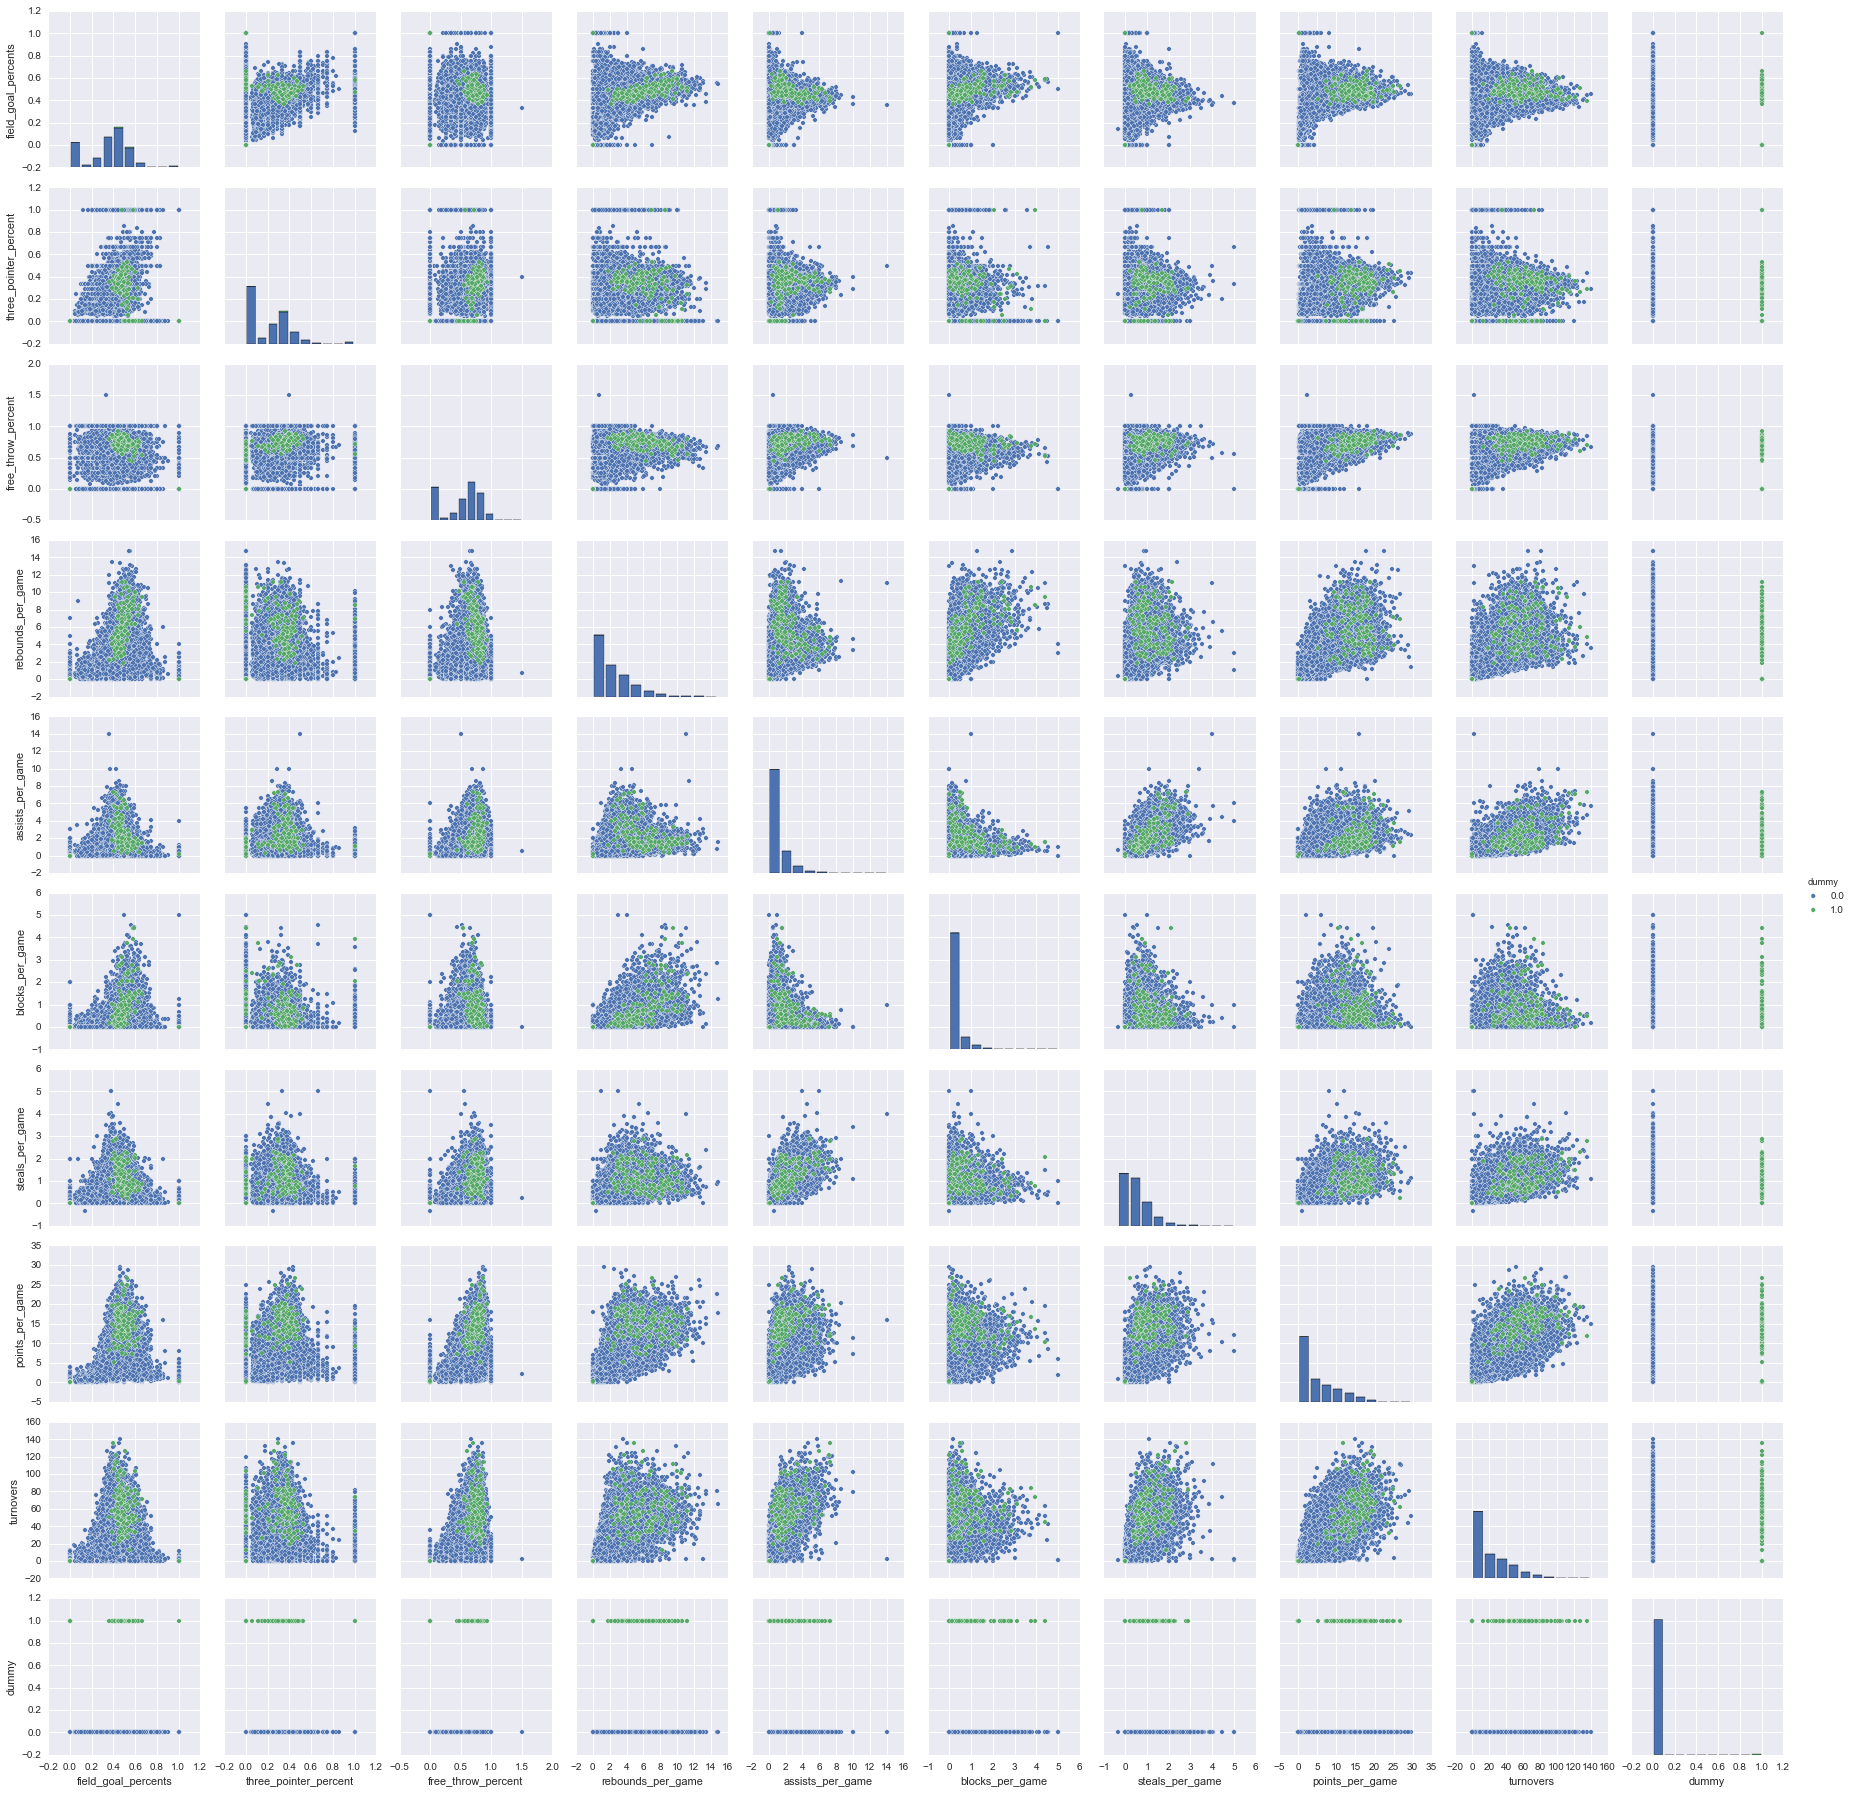

In [54]:
sns.pairplot(ncaa_draft_dd[['field_goal_percents',
       'three_pointer_percent','free_throw_percent',
       'rebounds_per_game','assists_per_game',
       'blocks_per_game','steals_per_game',
       'points_per_game', 'turnovers', 'dummy']], hue = 'dummy')


In [22]:
#PCA to explore the data and how they relate
#there should be some very obvious relationships already
# FGA - points, reb - blocks, FGM - FG%

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(X_cols)
ncaa_pca = PCA().fit(X_scaled)
ncaa_pca_t = ncaa_pca.transform(X_scaled)

def pca_summary(pca):
    return pd.DataFrame([np.sqrt(pca.explained_variance_), 
              pca.explained_variance_ratio_, 
              pca.explained_variance_ratio_.cumsum()],
             index = ["Standard deviation", "Proportion of Variance", "Cumulative Proportion"], 
             columns = (map("PC{}".format, range(1, len(pca.components_)+1))))

print "Standard deviations:\n\t " + ' '.join(map("{:.6}".format, np.sqrt(ncaa_pca.explained_variance_)))


Standard deviations:
	 3.51007 1.597 1.10461 1.013 0.820142 0.726423 0.656405 0.628333 0.54206 0.438342 0.349537 0.324827 0.204316 0.166261 0.148346 0.127014 0.116876 0.0960005 0.0917007 0.0651172


In [23]:
pca_summary(ncaa_pca)

PC1       PC2       PC3       PC4       PC5  \
Standard deviation      3.510066  1.596997  1.104605  1.013004  0.820142   
Proportion of Variance  0.616028  0.127520  0.061008  0.051309  0.033632   
Cumulative Proportion   0.616028  0.743548  0.804556  0.855865  0.889496   

                             PC6       PC7       PC8       PC9      PC10  \
Standard deviation      0.726423  0.656405  0.628333  0.542060  0.438342   
Proportion of Variance  0.026385  0.021543  0.019740  0.014691  0.009607   
Cumulative Proportion   0.915881  0.937424  0.957164  0.971856  0.981463   

                            PC11      PC12      PC13      PC14      PC15  \
Standard deviation      0.349537  0.324827  0.204316  0.166261  0.148346   
Proportion of Variance  0.006109  0.005276  0.002087  0.001382  0.001100   
Cumulative Proportion   0.987572  0.992847  0.994935  0.996317  0.997417   

                            PC16      PC17      PC18      PC19      PC20  
Standard deviation      0.127014  0.116876  0.096000  0.091701  0.065117  
Proportion of Variance  0.000807  0.000683  0.000461  0.000420  0.000212  
Cumulative Proportion   0.998224  0.998907  0.999368  0.999788  1.000000

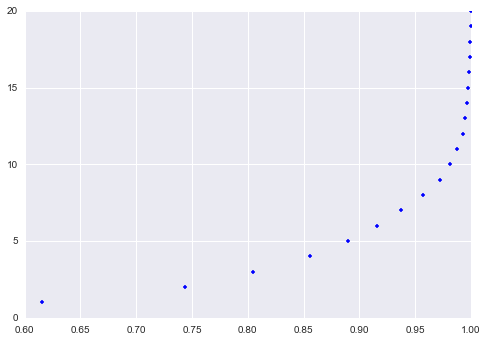

In [26]:
plt.plot(ncaa_pca.explained_variance_ratio_.cumsum(), range(1,21), 'b.' )

In [27]:
pd.DataFrame(ncaa_pca.components_, index=(map("PC{}".format, range(1,21))), columns=X_cols.columns).T

PC1       PC2       PC3       PC4       PC5  \
field_goals             0.272209 -0.044619  0.046727 -0.172599  0.127865   
field_goal_attempts     0.274333  0.025967  0.051389 -0.188824  0.075000   
field_goal_percents     0.138569 -0.129576 -0.574530  0.281668  0.242087   
three_pointers          0.196049  0.314263 -0.114805 -0.425197 -0.221053   
three_pointer_attempts  0.202556  0.313620 -0.083075 -0.395219 -0.218860   
three_pointer_percent   0.127151  0.217812 -0.550565  0.020689 -0.165130   
free_throws             0.256456 -0.028373  0.158235 -0.051723  0.327606   
free_throw_attemps      0.257445 -0.077714  0.167409 -0.016209  0.322279   
free_throw_percent      0.174284  0.047287 -0.421097  0.165097  0.122263   
rebounds                0.240236 -0.262266  0.030070 -0.028103  0.099544   
rebounds_per_game       0.228240 -0.283229 -0.036684  0.049023  0.093010   
assists                 0.227787  0.195508  0.192918  0.310705 -0.170355   
assists_per_game        0.216712  0.204085  0.147270  0.401371 -0.208096   
blocks                  0.139279 -0.482869 -0.034356 -0.113144 -0.395100   
blocks_per_game         0.125633 -0.494705 -0.069252 -0.076006 -0.433529   
steals                  0.248499  0.096403  0.140622  0.207855 -0.194362   
steals_per_game         0.229461  0.100229  0.083504  0.312038 -0.245021   
points                  0.271863  0.025039  0.048930 -0.196967  0.126406   
points_per_game         0.269766  0.001351 -0.030037 -0.113132  0.132880   
turnovers               0.261651  0.012818  0.119687  0.126610  0.053533   

                             PC6       PC7       PC8       PC9      PC10  \
field_goals            -0.051849 -0.050755  0.035627 -0.020680  0.006722   
field_goal_attempts     0.000813 -0.031542  0.022571 -0.032065  0.060771   
field_goal_percents    -0.078302 -0.372383  0.568700  0.129237  0.070867   
three_pointers          0.121036 -0.095693  0.174075 -0.058567 -0.000029   
three_pointer_attempts  0.158755 -0.094187  0.150232 -0.057771  0.055250   
three_pointer_percent  -0.618030  0.262962 -0.387917 -0.021294  0.031560   
free_throws            -0.098282  0.190316 -0.046768  0.358993 -0.062472   
free_throw_attemps     -0.128990  0.145525 -0.047415  0.292498 -0.003327   
free_throw_percent      0.725792  0.360887 -0.269504  0.067968  0.056169   
rebounds               -0.036467 -0.060026 -0.121695 -0.463402  0.304155   
rebounds_per_game       0.022147 -0.155013 -0.181245 -0.572606 -0.234601   
assists                -0.050439  0.284518  0.317510 -0.121836  0.108428   
assists_per_game       -0.022484  0.250932  0.250762 -0.172894 -0.362418   
blocks                 -0.014238  0.164972  0.078899  0.185823  0.159212   
blocks_per_game         0.033302  0.112192  0.080682  0.179124 -0.203489   
steals                  0.026075 -0.343585 -0.208810  0.198518  0.375975   
steals_per_game         0.072212 -0.477727 -0.347177  0.212125 -0.185871   
points                 -0.057388  0.012506  0.030650  0.082902 -0.023635   
points_per_game        -0.010054 -0.079565 -0.034578  0.026553 -0.540476   
turnovers              -0.028710  0.137230  0.063448 -0.098060  0.392602   

                            PC11      PC12      PC13      PC14      PC15  \
field_goals            -0.323251  0.401075 -0.018110  0.137000 -0.078682   
field_goal_attempts    -0.289363  0.208744 -0.039818  0.420233  0.427352   
field_goal_percents     0.054400 -0.023892  0.021657  0.000887  0.036969   
three_pointers          0.218776 -0.145728  0.034374 -0.167247 -0.359189   
three_pointer_attempts  0.169863 -0.211336  0.041687  0.195226  0.339523   
three_pointer_percent  -0.008485  0.011024 -0.031558  0.027627  0.016547   
free_throws             0.351233 -0.157029  0.000498  0.004907 -0.029515   
free_throw_attemps      0.293632 -0.182477  0.041144  0.152339  0.098083   
free_throw_percent     -0.012972  0.092298 -0.012196 -0.007607 -0.008325   
rebounds                0.258481  0.131524  0.187286 -0.019149  0.077087   

/Users/Zachary/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


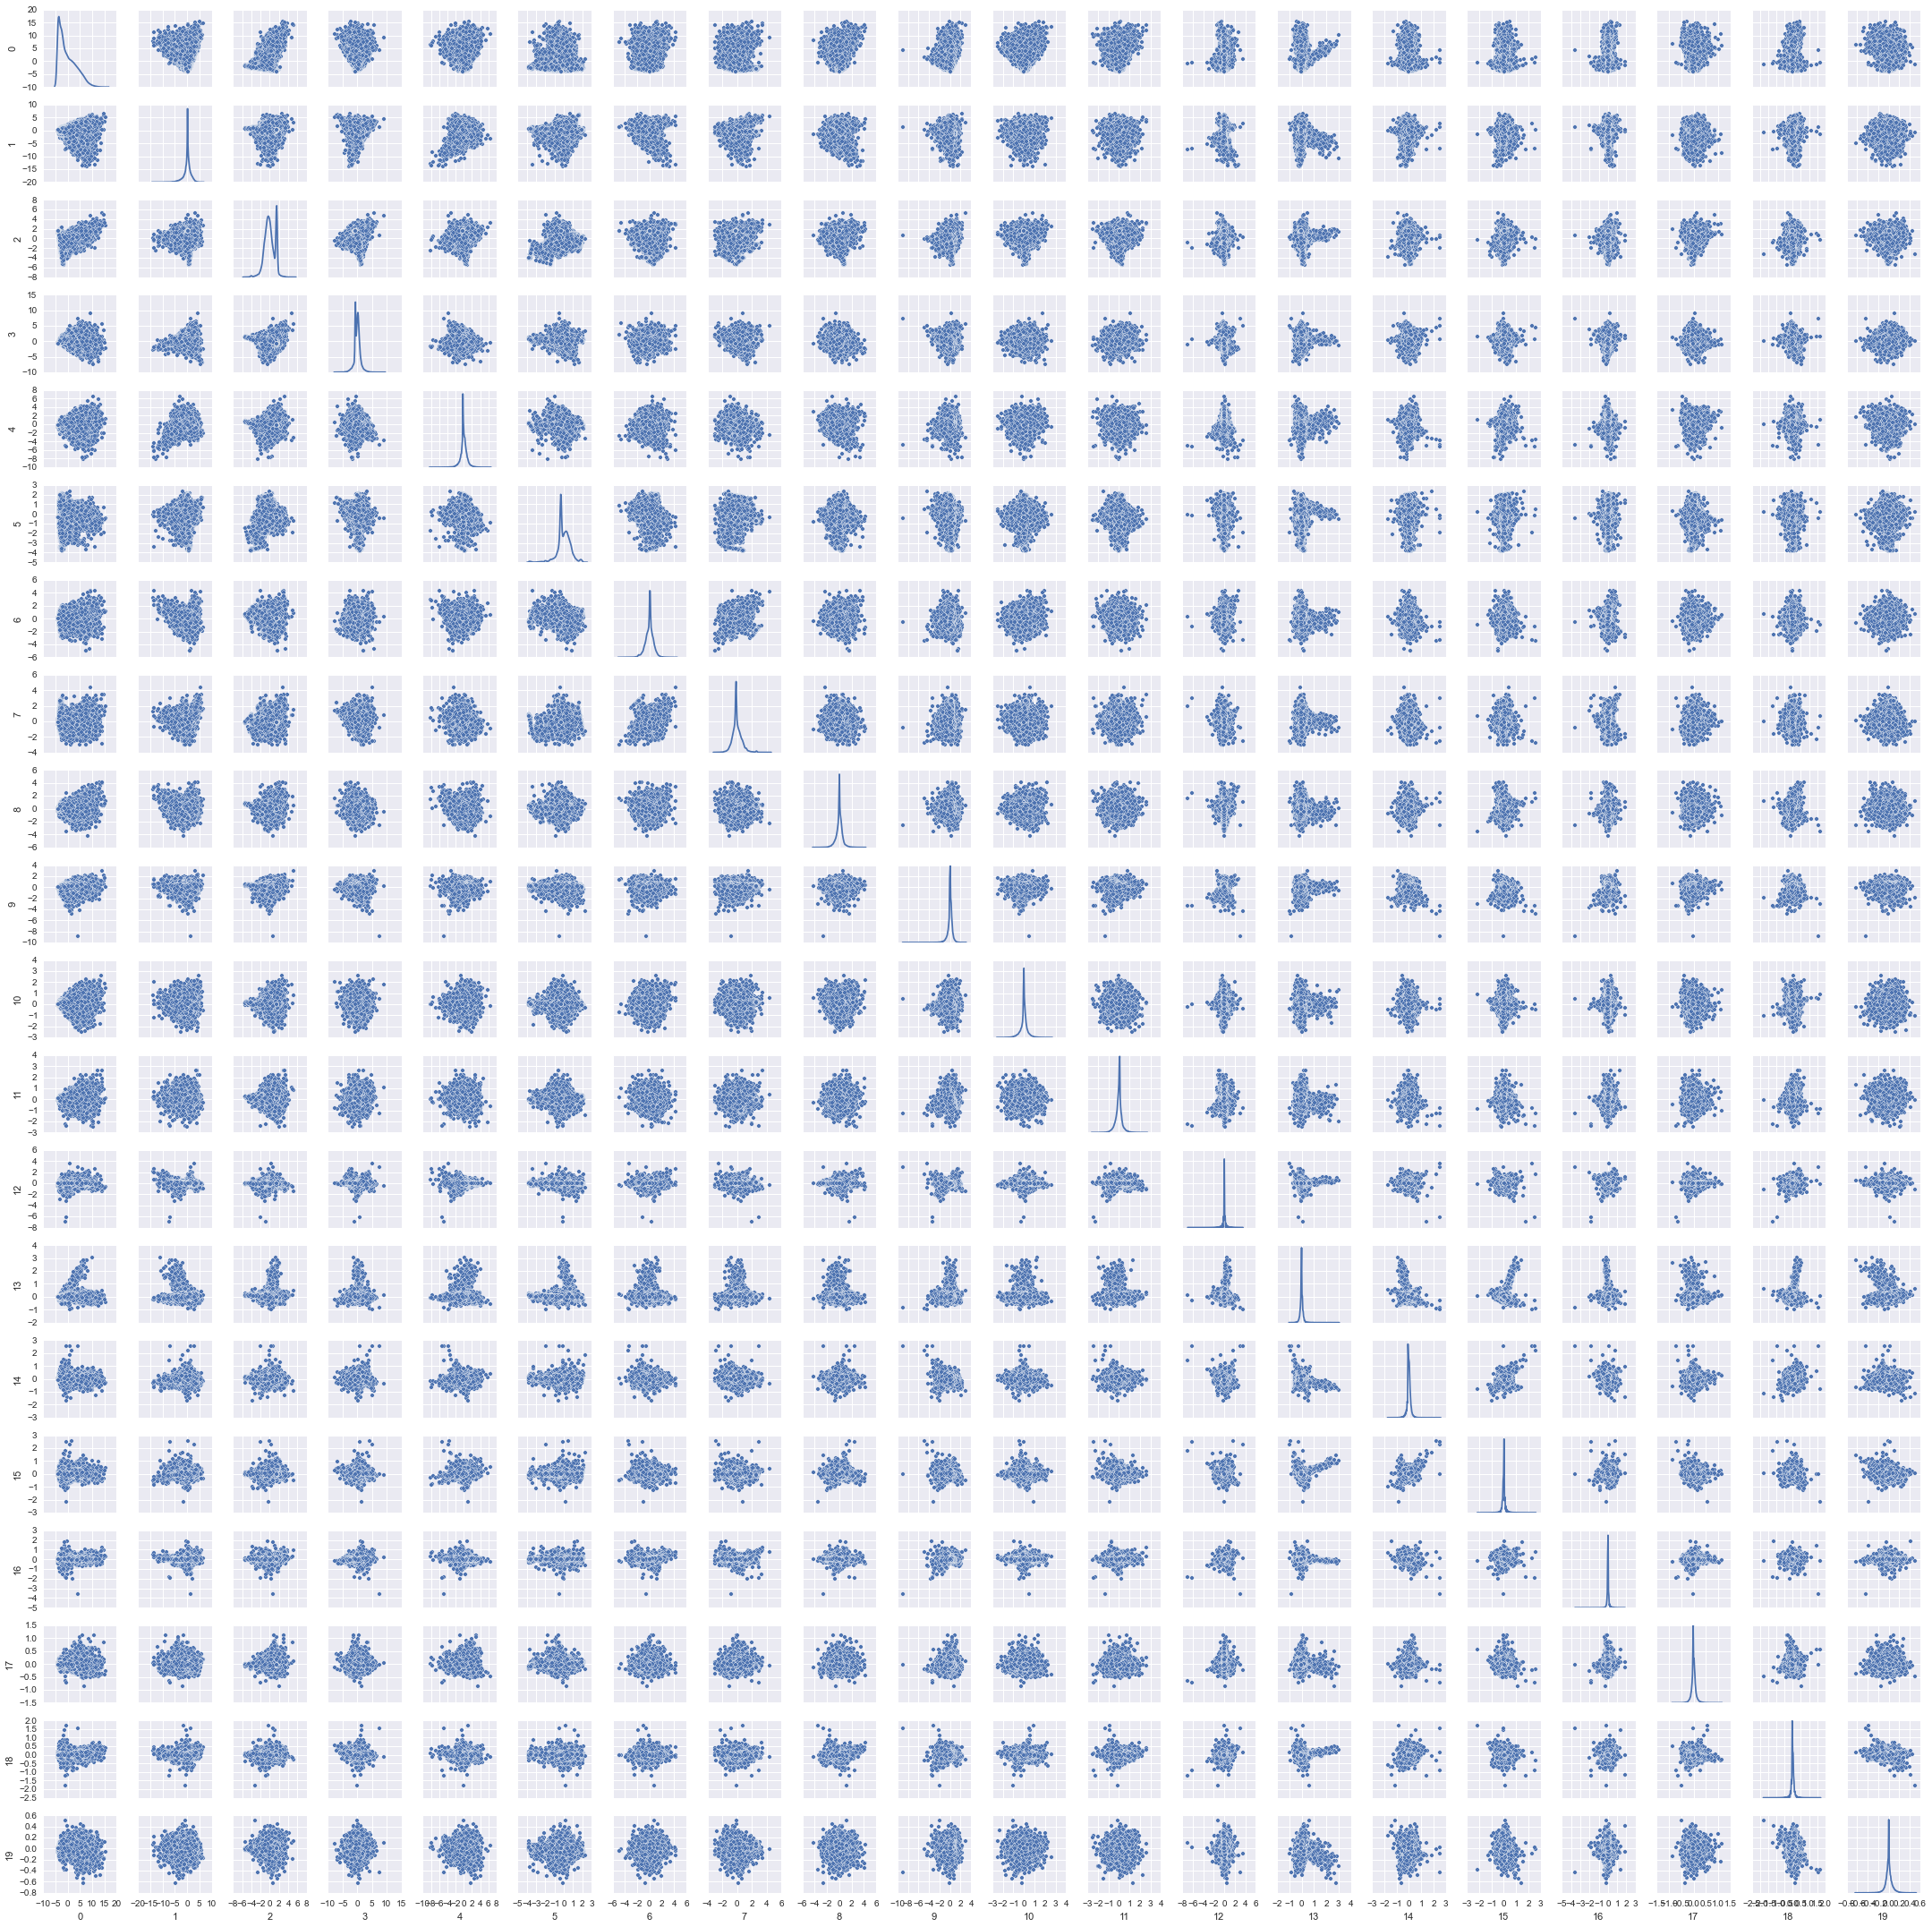

In [30]:
pc_df = pd.DataFrame(ncaa_pca_t)

sns.pairplot(pc_df, diag_kind='kde', size=1.5)

# So what now?
- Interpreting the PCA results
    - https://onlinecourses.science.psu.edu/stat505/print/book/export/html/49
    - http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues
- Creating a classifier model
    - Logistic regression?